# Imports
The file below must be ran before running any of the other files.

In [ ]:
import torch
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from datasets import load_dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold

from tqdm import tqdm

In [2]:
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Loading Data

In [3]:
def load_and_prepare_data(iter_num):

        if iter_num == 1 or 2:
            train_dataset = 'lelexuanzz/WELFake_stylo_feats'
            test_dataset = 'lelexuanzz/Gossipcop_Politifact_Test_Stylo'
        elif iter_num == 3:
            train_dataset = 'Paulozs/WELFake_embeddings'
            test_dataset = 'lelexuanzz/Gossipcop_Politifact_Test'

        train_dataset = load_dataset(train_dataset)
        test_dataset = load_dataset(test_dataset)

        train_df = train_dataset["train"].to_pandas()
        test_df = test_dataset["train"].to_pandas()
        print(f"Dataset loaded. Shape: {train_df.shape}")

        exclude_patterns = ['title','text', 'label']
        label_column = "label"

        if iter_num == 1:
            feature_columns = [col for col in train_df.columns if not any(pattern in col.lower() for pattern in exclude_patterns)][:10]
        elif iter_num == 2:
            feature_columns = [col for col in train_df.columns if not any(pattern in col.lower() for pattern in exclude_patterns)]

        X_train = train_df[feature_columns].values
        Y_train = train_df[label_column].values
        X_test = test_df[feature_columns].values
        Y_test = test_df[label_column].values

        print(f"Feature Column Shape: {X_train.shape}")
        print(f"Label Column Shape: {Y_train.shape}")
    
        return X_train, Y_train, X_test, Y_test

# KNN Base Model

In [4]:
def knn_model(X_train, y_train, X_test, y_test, k=5):

    print("Training baseline KNN model...")
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test)[:, 1] # Probability of the sample being FAKE.
    
    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba) 
    
    print(f"KNN Model accuracy: {accuracy:.4f}")
    print(f"KNN Model log loss: {loss:.4f}")

    return knn, accuracy, loss


## Hyperparameter Tunning on KNN Model
Using Grid Search to decide the hyperparameters to use.

In [5]:
def hyperparameter_tuning(X_train, y_train):

    print("Performing hyperparameter tuning with GridSearchCV...")

    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev']
    }
    
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(
        knn, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")
    print(f"Best CV score from GridSearchCV: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


# Cross Validation

In [8]:
def k_fold_cross_validation(best_model, X_train, y_train):
    
    print("Performing k-fold cross-validation...")
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in tqdm(kf.split(X_train), total=5):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        joblib.dump(best_model, 'temp_model.pkl')
        fold_model = joblib.load('temp_model.pkl')  # Temporary Model to avoid refitting
        fold_model.fit(X_train_fold, y_train_fold)
        score = fold_model.score(X_val_fold, y_val_fold)
        cv_scores.append(score)
    
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {np.mean(cv_scores):.4f}")
    print(f"Standard deviation of CV scores: {np.std(cv_scores):.4f}")
    
    return cv_scores

# Evaluation

In [14]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and visualize results"""
    print("Evaluating model on test set...")
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'report': report,
        'confusion_matrix': conf_matrix.tolist(),
    }
    
    return results

# Main Function

Starting KNN classification with stylometric features...
Dataset loaded. Shape: (62592, 20)
Feature Column Shape: (62592, 10)
Label Column Shape: (62592,)
Training baseline KNN model...
KNN Model accuracy: 0.5078
KNN Model log loss: 3.8343
Performing hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters from GridSearchCV: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Best CV score from GridSearchCV: 0.7084
Performing k-fold cross-validation...


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


Cross-validation scores: [0.7105200095854302, 0.7071651090342679, 0.7136123981466688, 0.6955583959098898, 0.7063428662725675]
Mean CV score: 0.7066
Standard deviation of CV scores: 0.0061
Evaluating model on test set...
Test Accuracy: 0.5235
Precision: 0.5014
Recall: 0.5235
F1 Score: 0.5110
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.68      0.66      4568
           1       0.25      0.21      0.23      2332

    accuracy                           0.52      6900
   macro avg       0.44      0.45      0.44      6900
weighted avg       0.50      0.52      0.51      6900

Best model saved to results/knn_model_best_weights.pkl
                  Model  Baseline Accuracy  \
0  KNN WELFake Stylo V1           0.507826   

                                     Best Parameters  CV Score (Mean)  \
0  {'metric': 'manhattan', 'n_neighbors': 15, 'we...          0.70664   

   CV Score (Std)  Test Accuracy  Precision    Recall  F1 Score

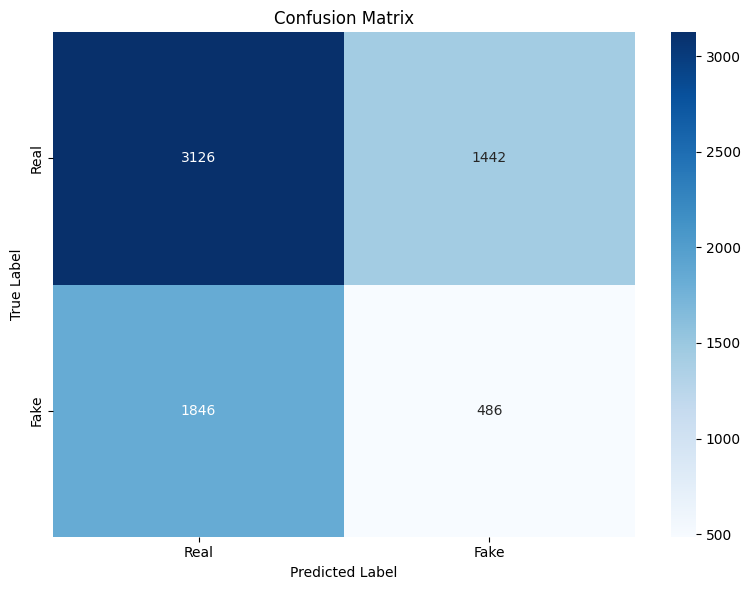

In [16]:
def main():

    print("Starting KNN classification with stylometric features...")

    iteration_num = 1

    # 1. Load and prepare data
    X_train, Y_train, X_test, Y_test= load_and_prepare_data(iteration_num)
    
    # 2. Training KNN Model
    model, knn_accuracy, knn_loss = knn_model(X_train, Y_train, X_test, Y_test)
    
    # 3. Hyperparameter tuning
    best_model, best_params, best_cv_score = hyperparameter_tuning(X_train, Y_train)
    
    # 4. K-fold cross-validation
    cv_scores = k_fold_cross_validation(best_model, X_train, Y_train)
    
    # 5. Final evaluation
    final_results = evaluate_model(best_model, X_test, Y_test)
    
    # 6. Save the best model
    model_path = 'results/knn_model_best_weights.pkl'
    joblib.dump(best_model, model_path)
    print(f"Best model saved to {model_path}")
    
    # 7. Save results to CSV
    results_df = pd.DataFrame({
        'Model': ['KNN WELFake Stylo V1'],
        'Baseline Accuracy': [knn_accuracy],
        'Best Parameters': [str(best_params)],
        'CV Score (Mean)': [np.mean(cv_scores)],
        'CV Score (Std)': [np.std(cv_scores)],
        'Test Accuracy': [final_results['accuracy']],
        'Precision': [final_results['precision']],
        'Recall': [final_results['recall']],
        'F1 Score': [final_results['f1']]
    })
    
    print(results_df)
    print(f"Iteration #{iteration_num} complete!")
    return best_model, final_results

if __name__ == "__main__":
    main()

In [ ]:
def main():

    print("Starting KNN classification with stylometric features...")

    iteration_num = 2

    # 1. Load and prepare data
    X_train, Y_train, X_test, Y_test= load_and_prepare_data(iteration_num)
    
    # 2. Training KNN Model
    model, knn_accuracy, knn_loss = knn_model(X_train, Y_train, X_test, Y_test)
    
    # 3. Hyperparameter tuning
    best_model, best_params, best_cv_score = hyperparameter_tuning(X_train, Y_train)
    
    # 4. K-fold cross-validation
    cv_scores = k_fold_cross_validation(best_model, X_train, Y_train)
    
    # 5. Final evaluation
    final_results = evaluate_model(best_model, X_test, Y_test)
    
    # 6. Save the best model
    model_path = 'results/knn_model_best_weights.pkl'
    joblib.dump(best_model, model_path)
    print(f"Best model saved to {model_path}")
    
    # 7. Save results to CSV
    results_df = pd.DataFrame({
        'Model': ['KNN WELFake Stylo V1'],
        'Baseline Accuracy': [knn_accuracy],
        'Best Parameters': [str(best_params)],
        'CV Score (Mean)': [np.mean(cv_scores)],
        'CV Score (Std)': [np.std(cv_scores)],
        'Test Accuracy': [final_results['accuracy']],
        'Precision': [final_results['precision']],
        'Recall': [final_results['recall']],
        'F1 Score': [final_results['f1']]
    })
    
    print(results_df)
    print(f"Iteration #{iteration_num} complete!")
    return best_model, final_results

if __name__ == "__main__":
    main()